In [50]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GroupShuffleSplit
#Uncomment below two lines if running on Google Collab. 
# from google.colab import drive
# drive.mount('/content/drive')
diabetes_dataset = pd.read_csv('diabetic_data.csv')
diabetes_dataset.drop(axis=1, columns=['weight', 'medical_specialty', 'payer_code'], inplace=True)
diabetes_dataset = diabetes_dataset.sort_values(by=['patient_nbr', 'encounter_id'])
# Define the ranges and replacement values
ICD9_mapping = [
    ((1, 139), 'Infectious And Parasitic Diseases'),
    ((140, 239), 'Neoplasms'),
    ((240, 279), 'Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders'),
    ((280, 289), 'Diseases Of The Blood And Blood-Forming Organs'),
    ((290, 319), 'Mental Disorders'),
    ((320, 389), 'Diseases Of The Nervous System And Sense Organs'),
    ((390, 459), 'Diseases Of The Circulatory System'),
    ((460, 519), 'Diseases Of The Respiratory System'),
    ((520, 579), 'Diseases Of The Digestive System'),
    ((580, 629), 'Diseases Of The Genitourinary System'),
    ((630, 679), 'Complications Of Pregnancy, Childbirth, And The Puerperium'),
    ((680, 709), 'Diseases Of The Skin And Subcutaneous Tissue'),
    ((710, 739), 'Diseases Of The Musculoskeletal System And Connective Tissue'),
    ((740, 759), 'Congenital Anomalies'),
    ((760, 779), 'Certain Conditions Originating In The Perinatal Period'),
    ((780, 799), 'Symptoms, Signs, And Ill-Defined Conditions'),
    ((800, 999), 'Injury And Poisoning'),
    ('V', 'Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services'),
    ('E', 'Supplementary Classification Of External Causes Of Injury And Poisoning')
]

# Custom function to replace values based on multiple ranges
def replace_multiple_ranges(x, ranges_and_values):
    for values, new_value in ranges_and_values:
        if type(values) == tuple and x[0] != 'V' and x[0] != 'E' and x != '?':
            if values[0] <= int(float(x)) <= values[1]:
                return new_value
        elif type(values) == str and x[0] == values:
            return new_value
    return x

In [51]:
# Apply the custom function to the diagnosis columns
diabetes_dataset['diag_1'] = diabetes_dataset['diag_1'].apply(replace_multiple_ranges, args=(ICD9_mapping,))
diabetes_dataset['diag_2'] = diabetes_dataset['diag_2'].apply(replace_multiple_ranges, args=(ICD9_mapping,))
diabetes_dataset['diag_3'] = diabetes_dataset['diag_3'].apply(replace_multiple_ranges, args=(ICD9_mapping,))

# Replace '?' with 'no record' across diag_2 and diag_3
diabetes_dataset[['diag_2', 'diag_3']] = diabetes_dataset[['diag_2', 'diag_3']].replace('?', 'no record')

# Replace '?' with NaN
diabetes_dataset[['race', 'diag_1']] = diabetes_dataset[['race', 'diag_1']].replace('?', np.nan)

# Drop rows with missing values in columns 'race' and 'diag_1'
diabetes_dataset.dropna(subset=['race', 'diag_1'], inplace=True)

In [52]:
admission_type_id_mapping = {1:'Emergency',
                             2:'Urgent',
                             3:'Elective',
                             4:'Newborn',
                             5:'Not Available',
                             6:'NULL',
                             7:'Trauma Center',
                             8:'Not Mapped'
                            }

discharge_disposition_id_mapping = {1: 'ischarged to home',
                                    2:'ischarged/transferred to another short term hospital',
                                    3:'ischarged/transferred to SNF',
                                    4:'ischarged/transferred to ICF',
                                    5:'ischarged/transferred to another type of inpatient care institution',
                                    6:'ischarged/transferred to home with home health service',
                                    7:'eft AMA',
                                    8:'ischarged/transferred to home under care of Home IV provider',
                                    9:'dmitted as an inpatient to this hospital',
                                    10:'Neonate discharged to another hospital for neonatal aftercare',
                                    11:'Expired',
                                    12:'Still patient or expected to return for outpatient services',
                                    13:'Hospice / home',
                                    14:'Hospice / medical facility',
                                    15:'Discharged/transferred within this institution to Medicare approved swing bed',
                                    16:'Discharged/transferred/referred another institution for outpatient services',
                                    17:'Discharged/transferred/referred to this institution for outpatient services',
                                    18:'NULL',
                                    19:'Expired at home. Medicaid only, hospice.',
                                    20:'Expired in a medical facility. Medicaid only, hospice.',
                                    21:'Expired, place unknown. Medicaid only, hospice.',
                                    22:'Discharged/transferred to another rehab fac including rehab units of a hospital.',
                                    23:'Discharged/transferred to a long term care hospital.',
                                    24:'Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.',
                                    25:'Not Mapped',
                                    26:'Unknown/Invalid',
                                    30:'Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere',
                                    27:'Discharged/transferred to a federal health care facility.',
                                    28:'Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital',
                                    29:'Discharged/transferred to a Critical Access Hospital (CAH).'
                                    }

admission_source_id_mapping = {1: 'Physician Referral',
                               2: 'Clinic Referral',
                               3: 'HMO Referral',
                               4: 'Transfer from a hospital',
                               5: 'Transfer from a Skilled Nursing Facility (SNF)',
                               6: 'Transfer from another health care facility',
                               7: 'Emergency Room',
                               8: 'Court/Law Enforcement',
                               9: 'Not Available',
                               10:' Transfer from critial access hospital',
                               11:' Normal Delivery',
                               12:' Premature Delivery',
                               13:' Sick Baby',
                               14:' Extramural Birth',
                               15:' Not Available',
                               17:' NULL',
                               18:' Transfer From Another Home Health Agency',
                               19:' Readmission to Same Home Health Agency',
                               20:' Not Mapped',
                               21:' Unknown/Invalid',
                               22:' Transfer from hospital inpt/same fac reslt in a sep claim',
                               23:' Born inside this hospital',
                               24:' Born outside this hospital',
                               25:' Transfer from Ambulatory Surgery Center',
                               26:' Transfer from Hospice'
                               }

diabetes_dataset['admission_type_id'] = diabetes_dataset['admission_type_id'].replace(admission_type_id_mapping)
diabetes_dataset['discharge_disposition_id'] = diabetes_dataset['discharge_disposition_id'].replace(discharge_disposition_id_mapping)
diabetes_dataset['admission_source_id'] = diabetes_dataset['admission_source_id'].replace(admission_source_id_mapping)

In [53]:
# Function to calculate differences between consecutive rows
def calculate_differences(diabetes_dataset, idx1, idx2):
    differences = {}
    for column in diabetes_dataset.columns:
        if column != 'readmitted':
            if pd.api.types.is_numeric_dtype(diabetes_dataset[column]):
                differences[column] = diabetes_dataset.at[idx1, column] - diabetes_dataset.at[idx2, column]
            else:
                differences[column] = 1 if diabetes_dataset.at[idx1, column] != diabetes_dataset.at[idx2, column] else 0
    return differences

# Function to identify shifts and calculate differences within a group
def process_group(group):
    shifts = ((group['readmitted'] == '<30') & ((group['readmitted'].shift(1) == 'NO') | (group['readmitted'].shift(1) == '>30')))
    shift_indices = group.index[shifts]


    differences_list = []
    for idx in shift_indices:
        if idx > group.index.min():
            prev_idx = group.index[group.index.get_loc(idx) - 1]  # Safely get the previous index
            differences = calculate_differences(group, prev_idx, idx)
            differences_list.append(differences)

    return differences_list

In [54]:
# Apply the function to each group and collect all differences
all_differences = []
for patient_id, group in diabetes_dataset.groupby('patient_nbr'):
    all_differences.extend(process_group(group))

# Convert list of differences to a DataFrame
differences_diabetes_dataset = pd.DataFrame(all_differences)

# Calculate the mean differences (normalize by the number of shifts)
normalized_differences = differences_diabetes_dataset.abs().mean()

# Get feature names with normalized difference value below 0.01
features_below_threshold = normalized_differences[normalized_differences < 0.01].index.tolist()


# Ensure the column to keep is not in the columns to drop
columns_to_drop = [col for col in features_below_threshold if col != 'patient_nbr']

diabetes_dataset_important_features = diabetes_dataset.drop(columns_to_drop, axis=1)
diabetes_dataset_important_features.drop(['encounter_id'], axis=1, inplace=True)

# Filtered Dataset

In [55]:
# uncomment the following lines to install the required packages
# ! pip install tensorflow
# ! pip install shap
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap

In [56]:
def load_data(dataset, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    # Ensure the proportions sum to 1.0
    assert train_size + val_size + test_size == 1.0, "Train, validation, and test sizes must sum to 1.0"

    # Split unique patient numbers into train, validation, and test sets
    unique_patients = dataset['patient_nbr'].unique()
    train_patients, remaining_patients = train_test_split(unique_patients, train_size=train_size, random_state=random_state)
    val_proportion = val_size / (val_size + test_size)
    val_patients, test_patients = train_test_split(remaining_patients, train_size=val_proportion, random_state=random_state)

    # Select records based on the patient splits
    train_set = dataset[dataset['patient_nbr'].isin(train_patients)]
    val_set = dataset[dataset['patient_nbr'].isin(val_patients)]
    test_set = dataset[dataset['patient_nbr'].isin(test_patients)]

    # Split features and labels
    def split_feature_label(data_set):
        features = data_set.drop(columns=['readmitted'])
        labels = data_set['readmitted']
        return features, labels

    train_features, train_labels = split_feature_label(train_set)
    val_features, val_labels = split_feature_label(val_set)
    test_features, test_labels = split_feature_label(test_set)

    return train_features, train_labels, val_features, val_labels, test_features, test_labels


In [57]:

from sklearn.preprocessing import StandardScaler, LabelEncoder
# Identify categorical features
categorical_features = diabetes_dataset_important_features.select_dtypes(include=['object', 'category']).columns.tolist()
#Encode Categorical Features
le_feat=LabelEncoder()
for col_name in categorical_features:
    diabetes_dataset_important_features[col_name] = le_feat.fit_transform(diabetes_dataset_important_features[col_name])
    le_name_mapping = dict(zip(le_feat.classes_, le_feat.transform(le_feat.classes_)))
    
(train_features, train_labels, val_features, val_labels, test_features, test_labels) = load_data(diabetes_dataset_important_features)
features_names=test_features.columns.values
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_labels_array=np.array(train_labels, dtype=np.float32)
train_features_array=np.array(train_features, dtype=np.float32)
test_labels_array=np.array(test_labels, dtype=np.float32)
test_features_array=np.array(test_features, dtype=np.float32)
val_features_array=np.array(val_features, dtype=np.float32)
val_labels_array=np.array(val_labels, dtype=np.float32)


In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

tf.random.set_seed(42)
model = Sequential([
    Dense(1024, activation='relu', input_shape=(train_features.shape[1],)),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(3, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler and early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_features_array, train_labels_array,
    epochs=50, batch_size=16,
    validation_split=0.2,
    callbacks=[lr_scheduler, early_stopping]
)



c:\Users\vedan\anaconda3\envs\AML_RL\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 80s 22ms/step - accuracy: 0.4970 - loss: 1.1149 - val_accuracy: 0.5443 - val_loss: 0.9320 - learning_rate: 0.0010
Epoch 2/50
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 72s 21ms/step - accuracy: 0.5673 - loss: 0.9093 - val_accuracy: 0.5310 - val_loss: 0.9282 - learning_rate: 0.0010
Epoch 3/50
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 72s 21ms/step - accuracy: 0.5675 - loss: 0.9077 - val_accuracy: 0.5462 - val_loss: 0.9258 - learning_rate: 0.0010
Epoch 4/50
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 73s 21ms/step - accuracy: 0.5766 - loss: 0.9016 - val_accuracy: 0.5209 - val_loss: 0.9371 - learning_rate: 0.0010
Epoch 5/50
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 72s 21ms/step - accuracy: 0.5783 - loss: 0.8978 - val_accuracy: 0.5167 - val_loss: 0.9401 - learning_rate: 0.0010
Epoch 6/50
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5788 - loss: 0.8940
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 81s 20ms/step - accurac

In [61]:
# Evaluate the model on test data
from sklearn.metrics import classification_report, accuracy_score
test_predictions = model.predict(test_features_array)
test_predictions_class = np.argmax(test_predictions, axis=1)

test_accuracy = accuracy_score(test_labels_array, test_predictions_class)
print(f'Test Accuracy: {test_accuracy}')
print('Test Classification Report:')
print(classification_report(test_labels_array, test_predictions_class))




466/466 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Test Accuracy: 0.5737781954887218
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.42      0.02      0.04      1699
         1.0       0.48      0.33      0.39      5206
         2.0       0.60      0.85      0.71      7991

    accuracy                           0.57     14896
   macro avg       0.50      0.40      0.38     14896
weighted avg       0.54      0.57      0.52     14896



# Generating Shap Values 

In [62]:
import shap
import numpy as np

# Ensure that the shapes are correct
print(f"Shape of train_features_array: {train_features_array.shape}")
print(f"Shape of test_features_array: {test_features_array.shape}")

# Initialize SHAP KernelExplainer with the model's prediction function
explainer = shap.KernelExplainer(model, train_features_array[:100])

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(test_features_array[:100])

# Ensure the shapes of shap_values and test_features_array are compatible
print(f"Shape of shap_values: {shap_values.shape}")

# Select a slice of test_features_array (e.g., the first 100 samples)
slice_indices = slice(0, 100)  # Adjust indices as needed
test_features_slice = test_features_array[slice_indices]




Shape of train_features_array: (69587, 28)
Shape of test_features_array: (14896, 28)


  0%|          | 0/100 [00:00<?, ?it/s]

Shape of shap_values: (100, 28, 3)


In [63]:
# Plot the SHAP summary plot for the selected slice
import matplotlib.pyplot as plt

def parse_classification_report(report):
    report_dict = report.splitlines()
    report_dict = [row.split() for row in report_dict[2:-3]]
    return report_dict

def plot_metrics(test_labels_array,test_predictions_class):
    data = parse_classification_report(classification_report(test_labels_array, test_predictions_class))

    # Extract metrics for plotting


    classes = [float(entry[0]) for entry in data[:3]]
    precision = [float(entry[1]) for entry in data[:3]]
    recall = [float(entry[2]) for entry in data[:3]]
    f1_score = [float(entry[3]) for entry in data[:3]]

    # Create a figure and a single axis
    fig, ax1 = plt.subplots(figsize=(15, 10))

    # Plot bars
    bar_width = 0.2
    opacity = 0.8

    bar1 = ax1.bar([c - bar_width for c in classes], precision, bar_width, alpha=opacity, color='b', label='Precision')
    bar2 = ax1.bar(classes, recall, bar_width, alpha=opacity, color='g', label='Recall')
    bar3 = ax1.bar([c + bar_width for c in classes], f1_score, bar_width, alpha=opacity, color='r', label='F1-score')

    # Function to add value labels on top of bars
    def add_value_labels(ax, bars, values):
        for bar, value in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{value:.2f}', ha='center', va='bottom')

    add_value_labels(ax1, bar1, precision)
    add_value_labels(ax1, bar2, recall)
    add_value_labels(ax1, bar3, f1_score)

    # Add labels, title, and legend
    ax1.set_xlabel('Classes')
    ax1.set_ylabel('Scores')
    ax1.set_title('Classification Metrics by Class')
    ax1.set_xticks(classes)
    ax1.legend()

    # Show plot
    plt.show()

# Plotting Results for Filtered Dataset

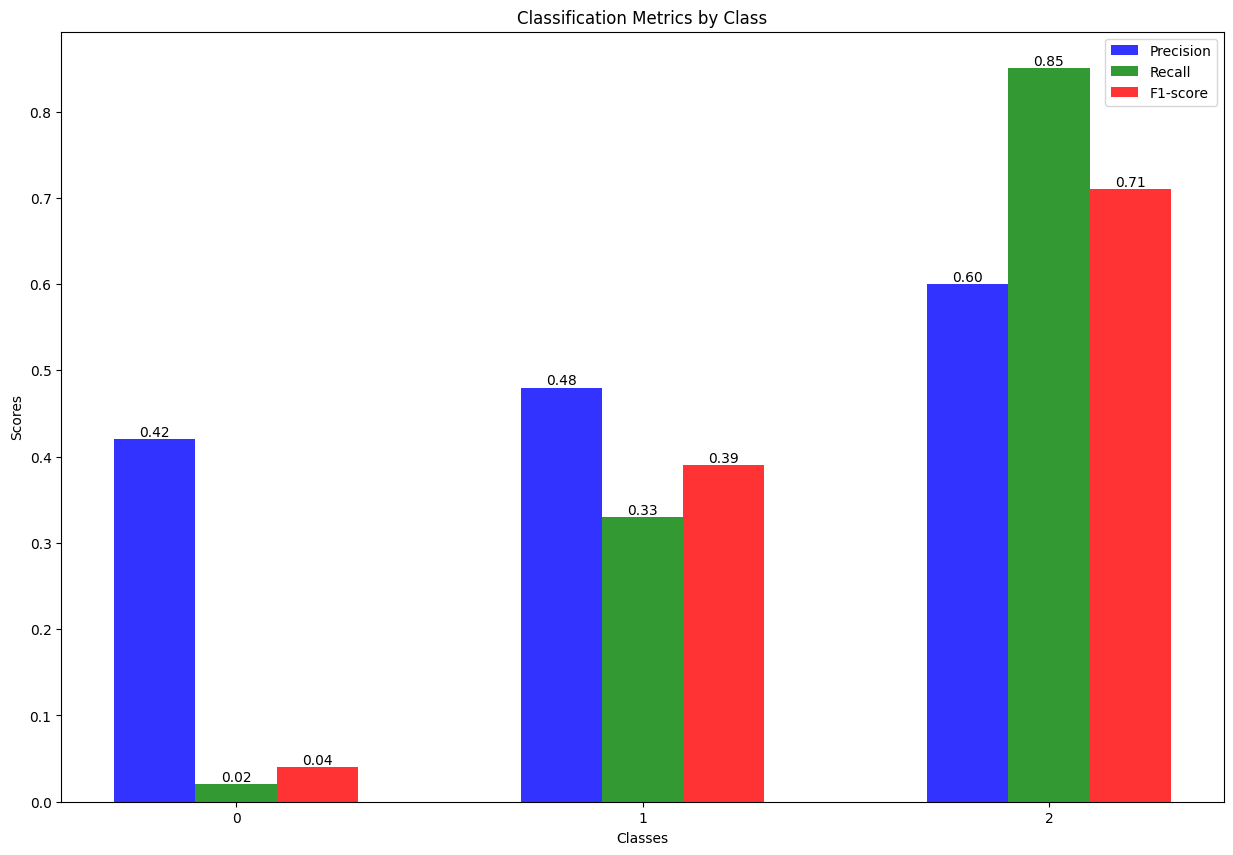

In [64]:
plot_metrics(test_labels_array,test_predictions_class)

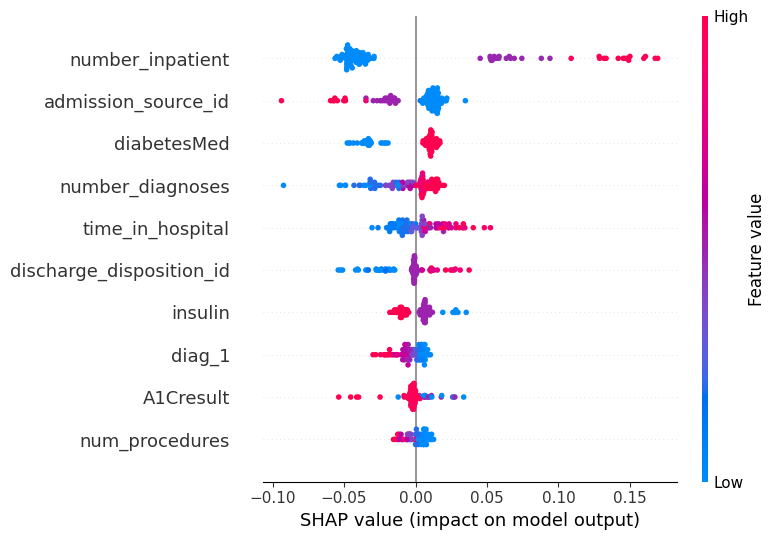

In [65]:
#Shap Value for <30 Days Readmission
shap.summary_plot(shap_values[:,:,1], test_features_slice, max_display=10,feature_names=features_names)

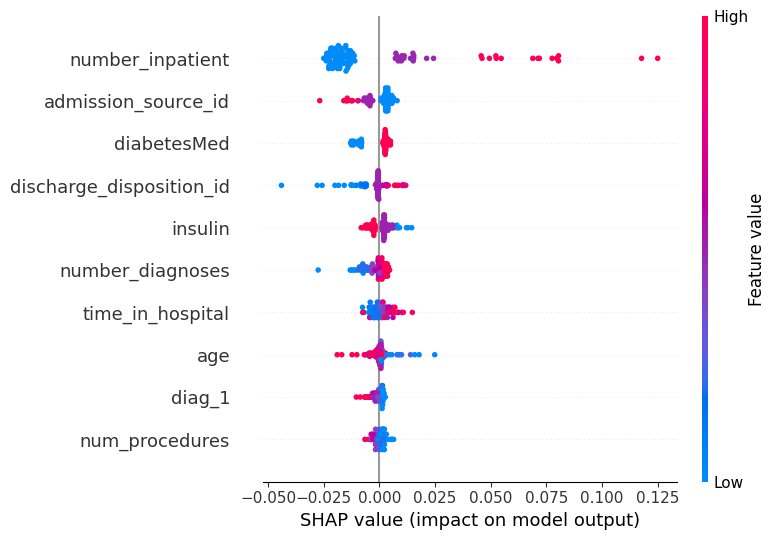

In [66]:
#Shap Values for >30 Days Readmission
shap.summary_plot(shap_values[:,:,0], test_features_slice, max_display=10,feature_names=features_names)

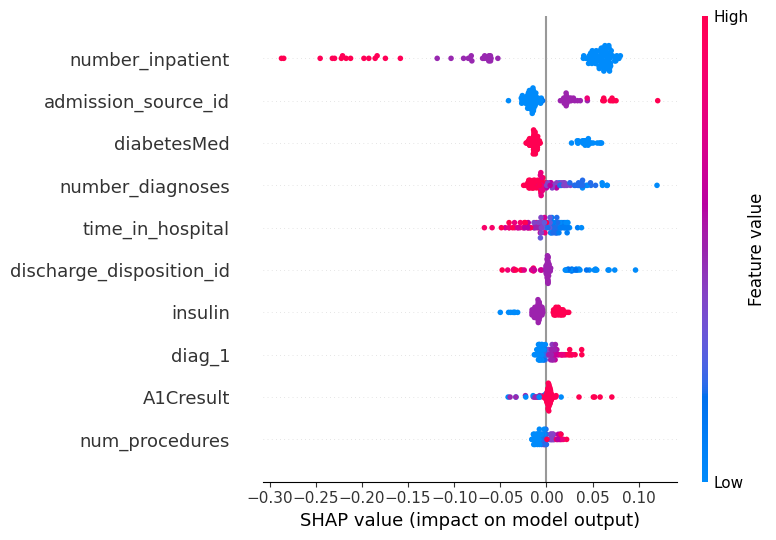

In [67]:
#Shap Values for No Readmissions
shap.summary_plot(shap_values[:,:,2], test_features_slice, max_display=10,feature_names=features_names)

# Unfiltered Data

In [68]:

categorical_features_unfiltered = diabetes_dataset.select_dtypes(include=['object', 'category']).columns.tolist()
#LAbelling the categorical features
le_feat_unfiltered=LabelEncoder()
for col_name in categorical_features_unfiltered:
    diabetes_dataset[col_name] = le_feat_unfiltered.fit_transform(diabetes_dataset[col_name])
    le_name_mapping_unfiltered = dict(zip(le_feat_unfiltered.classes_, le_feat_unfiltered.transform(le_feat_unfiltered.classes_)))
    
(train_features_unfiltered, train_labels_unfiltered, val_features_unfiltered, val_labels_unfiltered, test_features_unfiltered, test_labels_unfiltered) = load_data(diabetes_dataset)
features_names_unfiltered=test_features_unfiltered.columns.values
scaler_unfiltered = StandardScaler()
train_features_unfiltered = scaler_unfiltered.fit_transform(train_features_unfiltered)
val_features_unfiltered = scaler_unfiltered.transform(val_features_unfiltered)
test_features_unfiltered = scaler_unfiltered.transform(test_features_unfiltered)

#Typecaste to array for the neural network
train_labels_array_unfiltered=np.array(train_labels_unfiltered, dtype=np.float32)
train_features_array_unfiltered=np.array(train_features_unfiltered, dtype=np.float32)
test_labels_array_unfiltered=np.array(test_labels_unfiltered, dtype=np.float32)
test_features_array_unfiltered=np.array(test_features_unfiltered, dtype=np.float32)
val_features_array_unfiltered=np.array(val_features_unfiltered, dtype=np.float32)
val_labels_array_unfiltered=np.array(val_labels_unfiltered, dtype=np.float32)


In [69]:
tf.random.set_seed(42)
model_unfiltered = Sequential([
    Dense(1024, activation='relu', input_shape=(train_features_unfiltered.shape[1],)),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(3, activation='softmax')
])

optimizer_unfiltered = Adam(learning_rate=0.001)
model_unfiltered.compile(optimizer=optimizer_unfiltered, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler and early stopping
lr_scheduler_unfiltered = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping_unfiltered = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history_unfiltered = model_unfiltered.fit(
    train_features_array_unfiltered, train_labels_array_unfiltered,
    epochs=50, batch_size=16,
    validation_split=0.2,
    callbacks=[lr_scheduler_unfiltered, early_stopping_unfiltered]
)

c:\Users\vedan\anaconda3\envs\AML_RL\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 92s 24ms/step - accuracy: 0.4963 - loss: 1.1241 - val_accuracy: 0.5692 - val_loss: 0.9110 - learning_rate: 0.0010
Epoch 2/50
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 85s 24ms/step - accuracy: 0.5752 - loss: 0.9028 - val_accuracy: 0.5706 - val_loss: 0.9071 - learning_rate: 0.0010
Epoch 3/50
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 85s 24ms/step - accuracy: 0.5793 - loss: 0.8980 - val_accuracy: 0.5601 - val_loss: 0.9110 - learning_rate: 0.0010
Epoch 4/50
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 85s 25ms/step - accuracy: 0.5823 - loss: 0.8945 - val_accuracy: 0.5555 - val_loss: 0.9214 - learning_rate: 0.0010
Epoch 5/50
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 78s 22ms/step - accuracy: 0.5842 - loss: 0.8900 - val_accuracy: 0.5675 - val_loss: 0.9053 - learning_rate: 0.0010
Epoch 6/50
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 73s 21ms/step - accuracy: 0.5897 - loss: 0.8818 - val_accuracy: 0.5687 - val_loss: 0.9030 - learning_rate: 0.0010
Epoch 7/50
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 72s 21ms/step - accura

In [70]:

test_predictions_unfiltered = model_unfiltered.predict(test_features_array_unfiltered)
test_predictions_class_unfiltered = np.argmax(test_predictions_unfiltered, axis=1)

test_accuracy = accuracy_score(test_labels_array_unfiltered, test_predictions_class_unfiltered)
print(f'Test Accuracy: {test_accuracy}')
print('Test Classification Report:')
print(classification_report(test_labels_array_unfiltered, test_predictions_class_unfiltered))




466/466 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Test Accuracy: 0.583109559613319
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.35      0.01      0.03      1699
         1.0       0.50      0.39      0.44      5206
         2.0       0.62      0.83      0.71      7991

    accuracy                           0.58     14896
   macro avg       0.49      0.41      0.39     14896
weighted avg       0.55      0.58      0.54     14896



# Generating Shap Values For Unfiltered Dataset

In [71]:
# Ensure that the shapes are correct
print(f"Shape of unfiltered train_features_array: {train_features_array_unfiltered.shape}")
print(f"Shape of unfiltered test_features_array: {test_features_array_unfiltered.shape}")

# Initialize SHAP KernelExplainer with the model's prediction function
explainer_unfiltered = shap.KernelExplainer(model_unfiltered, train_features_array_unfiltered[:100])

# Calculate SHAP values for the test set
shap_values_unfiltered = explainer_unfiltered.shap_values(test_features_array_unfiltered[:100])

# Ensure the shapes of shap_values and test_features_array are compatible
print(f"Shape of shap_values: {shap_values_unfiltered.shape}")

# Select a slice of test_features_array (e.g., the first 100 samples)
slice_indices = slice(0, 100)  # Adjust indices as needed
test_features_slice_unfiltered = test_features_array_unfiltered[slice_indices]

Shape of unfiltered train_features_array: (69587, 46)
Shape of unfiltered test_features_array: (14896, 46)


  0%|          | 0/100 [00:00<?, ?it/s]

Shape of shap_values: (100, 46, 3)


# Plotting Results For Unfiltered Dataset

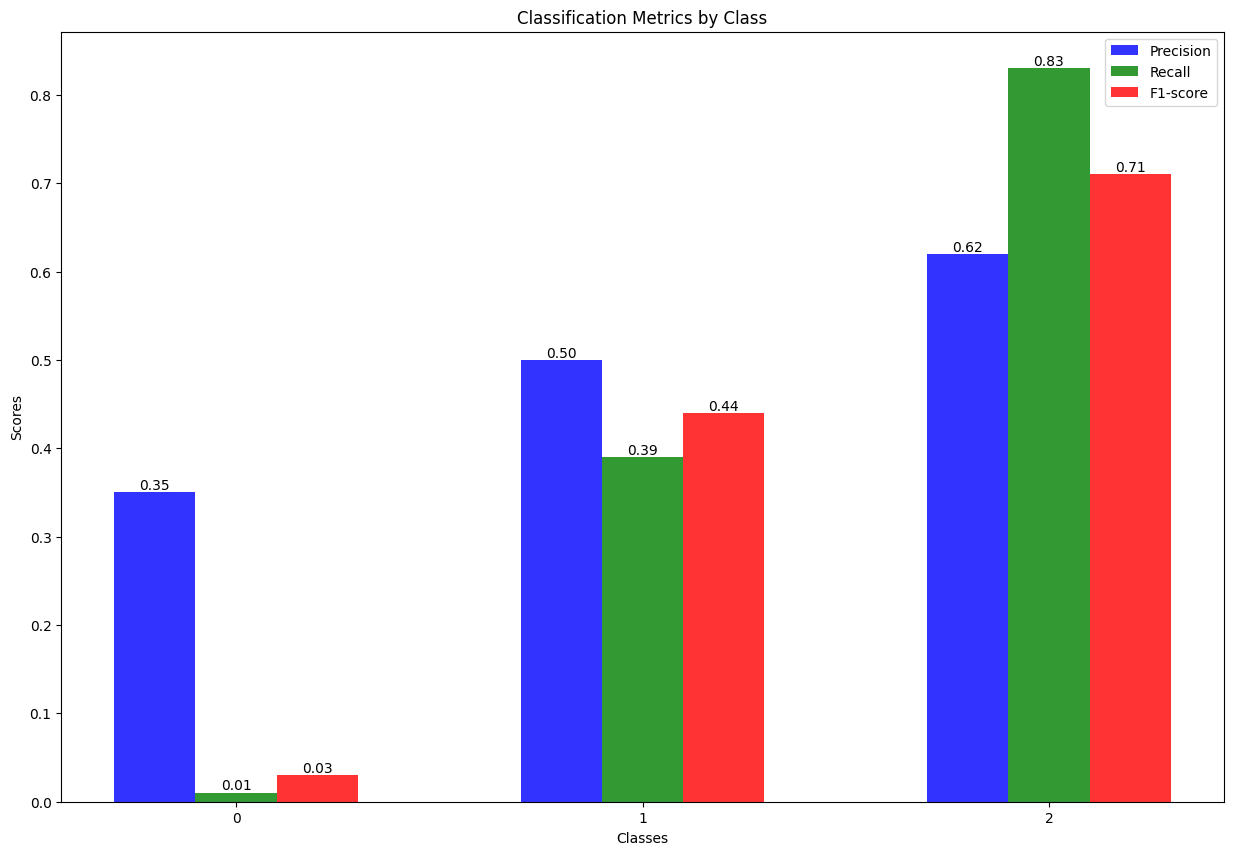

In [72]:
#Plotting Performance Metrics for the Unfiltered Dataset
plot_metrics(test_labels_array_unfiltered,test_predictions_class_unfiltered)

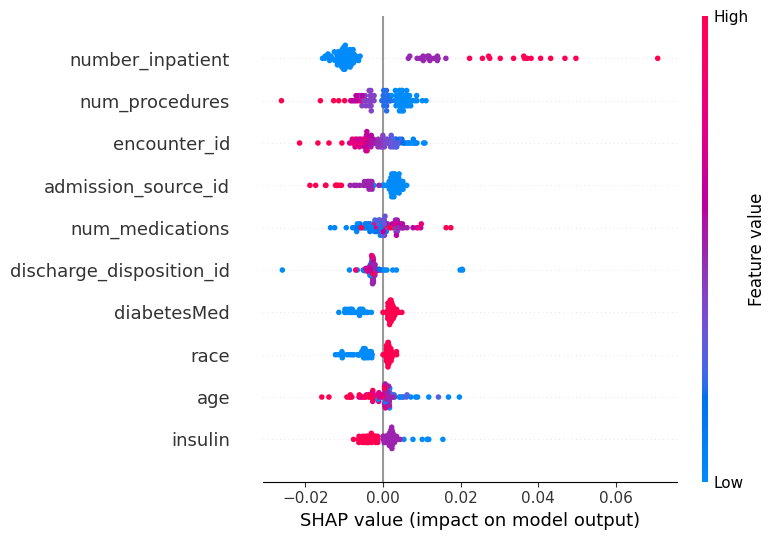

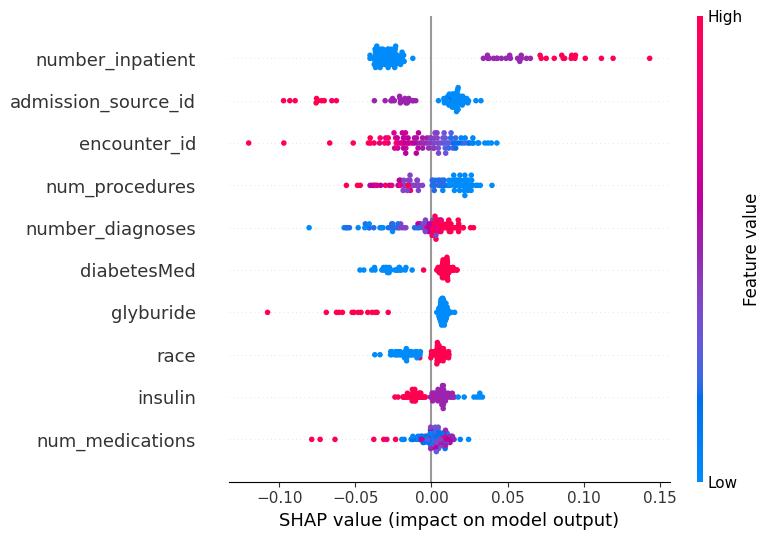

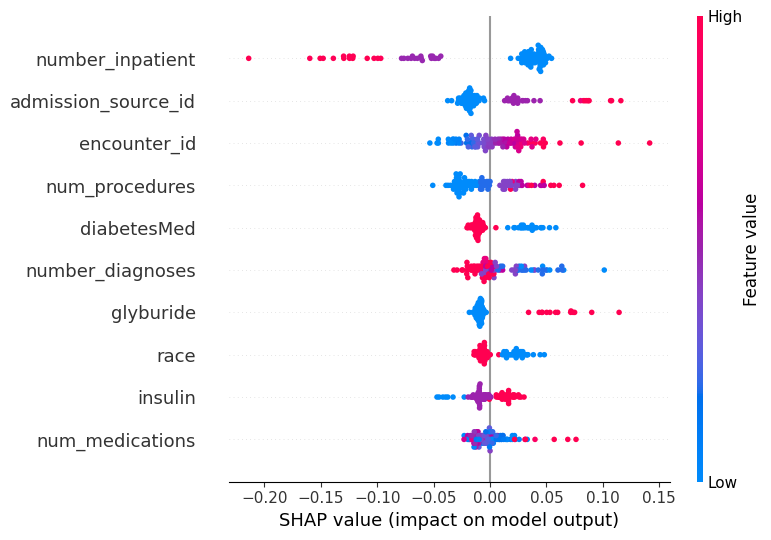

In [73]:
shap.summary_plot(shap_values_unfiltered[:,:,0], test_features_slice_unfiltered, max_display=10,feature_names=features_names_unfiltered)
shap.summary_plot(shap_values_unfiltered[:,:,1], test_features_slice_unfiltered, max_display=10,feature_names=features_names_unfiltered)
shap.summary_plot(shap_values_unfiltered[:,:,2], test_features_slice_unfiltered, max_display=10,feature_names=features_names_unfiltered)